predict outcome = live release through adoption

or 

dead release (deceased, euthanized, disposal,
missing)

to become no kill

Does dog breed affect outcome?
Does cat breed affect outcome?

Does age affect outcome? Puppies/kittens have more live releases?

Does sex affect outcome?

Does species affect outcome?

Does having a name affect outcome?

SCRP - stray cat return program

### Import Packages

In [1]:
import pandas as pd
from sodapy import Socrata
import config
import numpy as np
import datetime

import pandas as pd
pd.set_option("display.max_columns", 2200)
pd.set_option("display.max_rows", 200)
import numpy as np
import seaborn  as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
%matplotlib inline  
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations
import re
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Keeping track of runtime.
import timeit

# Decision trees
from sklearn import tree
from IPython.display import Image

# Packages for rendering tree.
import pydotplus
import graphviz

import itertools #(for confusion matrix)

### Import Data

In [2]:
# intake database
intakes = pd.read_csv('austin_animal_center_intakes.csv')

In [3]:
# outcome database
out = pd.read_csv('austin_animal_center_outcomes.csv')

In [4]:
intakes.head(1)

,Unnamed: 0,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake
0,0,1 year,A792238,Dog,American Bulldog Mix,Brown/White,2019-06-24T21:09:00.000,2019-06-24T21:09:00.000,Red River And Cesar Chavez in Austin (TX),Normal,Stray,Cujo,Intact Male


In [5]:
out.head(1)

,Unnamed: 0,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,0,8 years,A790111,Cat,Domestic Shorthair Mix,Blue Tabby,2011-03-04T00:00:00.000,2019-06-25T07:58:00.000,2019-06-25T07:58:00.000,*Rick,Foster,Adoption,Neutered Male


### Initial Data Transformation

In [6]:
# some initial data transformation

def transform_age(df, age_column):
    
    """
    Function to standardize ages:
    1) split the age_upon_intake column into a
    column containing the number and a column 
    containing the time period (weeks, month or year)
    2) calculate the age in an age in days column and 
    an age in years column
    """
    
    df = df.loc[df.loc[:, age_column] != 'NULL']
    range_column = age_column +'_calen_time'
    df['age_in_d_w_or_y'], df[range_column] = df.loc[:, age_column].str.split(' ').str[0].fillna(0).astype(int), df.loc[:, age_column].str.split(' ').str[1].fillna(0)
    df[range_column] = np.where(df[range_column].str.contains('day'), 1, 
                            np.where(df[range_column].str.contains('week'), 7, 
                                np.where(df[range_column].str.contains('month'), 30, 
                                    np.where(df[range_column].str.contains('year'), 365, 0)))).astype(int)
    df[age_column + '_in_days'] = df[range_column] * df['age_in_d_w_or_y']
    df[age_column + '_in_years'] = df[age_column + '_in_days']/365
    return df

def transform_date(df, event):
    
    """
    Function to:
    1) convert intake datetime
    2) split datetime into separate month,
    year and weekday columns
    """
    
    event_date = event + '_datetime'
    df[event_date] = pd.to_datetime(df['datetime'])
    df[event + '_month'] = df[event_date].dt.month
    df[event + '_year'] = df[event_date].dt.year
    df[event + '_weekday'] = df[event_date].dt.weekday_name
    df.rename(columns={event + '_name': 'name'}, inplace=True)
    return df

def create_unique_id(df, event):
    
    """
    an animal that had come in and out of  
    the shelter more than once would be given the
    same animal_id number for each intake, 
    therefore it was necessery to create a unique 
    animal id for each animal to eliminate what may
    be viewed as duplicate entries
    """
    
    df.reset_index(inplace=True)               
    df[event + '_number'] = df.groupby(['animal_id'])[event + '_datetime'].rank(method='dense', ascending=False)
    df['animal_id_new'] = df['animal_id'] + '_' + df[event + '_number'].astype(int).astype(str)
    return df
    
def transform_birthdates(df):
    
    """
    Function to:
    1) convert date of birth column to datetime
    2) split datetime into separate month and year 
    columns
    """
    
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
    df['dob_year'] = df['date_of_birth'].dt.year
    df['dob_month'] = df['date_of_birth'].dt.month
    return df

In [7]:
# running initial data transformation functions
# on intake dataframe

intakes = transform_age(intakes, 'age_upon_intake')
intakes = transform_date(intakes, 'intake')

# an animal that had come in and out of  
# the shelter more than once would be given the
# same animal_id number for each intake, 
# therefore it was necessery to create a unique 
# animal id for each animal to eliminate what may
# be viewed as duplicate entries

intakes.reset_index(inplace=True)
intakes['intake_number'] = intakes.groupby(['animal_id'])['intake_datetime'].rank(method='dense', ascending=False)
intakes['animal_id_new'] = intakes['animal_id'] + '_' + intakes['intake_number'].astype(int).astype(str)

# running initial data transformation functions
# on outcome dataframe

out = transform_age(out, 'age_upon_outcome')
out = transform_date(out, 'outcome')
out = create_unique_id(out, 'outcome')
out = transform_birthdates(out)

In [8]:
intakes.head(1)

,index,Unnamed: 0,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake,age_in_d_w_or_y,age_upon_intake_calen_time,age_upon_intake_in_days,age_upon_intake_in_years,intake_datetime,intake_month,intake_year,intake_weekday,intake_number,animal_id_new
0,0,0,1 year,A792238,Dog,American Bulldog Mix,Brown/White,2019-06-24T21:09:00.000,2019-06-24T21:09:00.000,Red River And Cesar Chavez in Austin (TX),Normal,Stray,Cujo,Intact Male,1,365,365,1.0,2019-06-24 21:09:00,6,2019,Monday,1.0,A792238_1


In [9]:
out.head(1)

,index,Unnamed: 0,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_in_d_w_or_y,age_upon_outcome_calen_time,age_upon_outcome_in_days,age_upon_outcome_in_years,outcome_datetime,outcome_month,outcome_year,outcome_weekday,outcome_number,animal_id_new,dob_year,dob_month
0,0,0,8 years,A790111,Cat,Domestic Shorthair Mix,Blue Tabby,2011-03-04,2019-06-25T07:58:00.000,2019-06-25T07:58:00.000,*Rick,Foster,Adoption,Neutered Male,8,365,2920,8.0,2019-06-25 07:58:00,6,2019,Tuesday,1.0,A790111_1,2011,3


In [10]:
# dropping unneccessary columns and columns that will
# be duplicated when dataframes merged

int_cols_to_drop = ['Unnamed: 0', 'index']
out_cols_to_drop = ['Unnamed: 0', 'index', 'animal_type', 'breed', 'color', 'age_in_d_w_or_y']

intakes.drop(int_cols_to_drop, axis=1, inplace=True)
out.drop(out_cols_to_drop, axis=1, inplace=True)

In [11]:
# merge intake and outcome databases

intakes.set_index('animal_id_new', inplace=True)
out.set_index('animal_id_new', inplace=True)

df = pd.merge(out, intakes, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_intake'])

In [12]:
df.head(1)

,age_upon_outcome,animal_id_outcome,date_of_birth,datetime_outcome,monthyear,name_outcome,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_calen_time,age_upon_outcome_in_days,age_upon_outcome_in_years,outcome_datetime,outcome_month,outcome_year,outcome_weekday,outcome_number,dob_year,dob_month,age_upon_intake,animal_id_intake,animal_type,breed,color,datetime_intake,datetime2,found_location,intake_condition,intake_type,name_intake,sex_upon_intake,age_in_d_w_or_y,age_upon_intake_calen_time,age_upon_intake_in_days,age_upon_intake_in_years,intake_datetime,intake_month,intake_year,intake_weekday,intake_number
animal_id_new,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A006100_1,10 years,A006100,2007-07-09,2017-12-07T00:00:00.000,2017-12-07T00:00:00.000,Scamp,NaN,Return to Owner,Neutered Male,365,3650,10.0,2017-12-07,12,2017,Thursday,1.0,2007,7,10 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,2017-12-07T14:07:00.000,2017-12-07T14:07:00.000,Colony Creek And Hunters Trace in Austin (TX),Normal,Stray,Scamp,Neutered Male,10,365,3650,10.0,2017-12-07 14:07:00,12,2017,Thursday,1.0


In [13]:
# dropping unneccessary columns

col_to_drop = ['age_upon_outcome_calen_time', 'animal_id_outcome', 'outcome_number', 
'dob_year', 'age_upon_outcome_calen_time', 'animal_id_outcome', 'outcome_number', 'dob_year', 
'animal_id_intake', 'found_location', 'age_in_d_w_or_y', 'age_upon_intake_calen_time']

df.drop(col_to_drop, axis=1, inplace=True)

In [14]:
# creating new columns of time in shelter, ages at intake and outcome and intake and outcome dates

df['time_in_shelter'] = df['outcome_datetime'] - df['intake_datetime']
df['age_at_intake'] = df['intake_datetime'] - df['date_of_birth']
df['age_at_outcome'] = df['outcome_datetime'] - df['date_of_birth']
df['intake_date'] = pd.to_datetime(df['intake_datetime']).dt.date
df['outcome_date'] = pd.to_datetime(df['datetime_outcome']).dt.date

In [15]:
# dropping unneccessary columns

df.drop(['date_of_birth','datetime_intake', 'datetime2', 'age_upon_intake', 
         'dob_month', 'outcome_datetime'], axis=1, inplace=True)

In [16]:
df.head(1)

,age_upon_outcome,datetime_outcome,monthyear,name_outcome,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_in_days,age_upon_outcome_in_years,outcome_month,outcome_year,outcome_weekday,animal_type,breed,color,intake_condition,intake_type,name_intake,sex_upon_intake,age_upon_intake_in_days,age_upon_intake_in_years,intake_datetime,intake_month,intake_year,intake_weekday,intake_number,time_in_shelter,age_at_intake,age_at_outcome,intake_date,outcome_date
animal_id_new,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A006100_1,10 years,2017-12-07T00:00:00.000,2017-12-07T00:00:00.000,Scamp,NaN,Return to Owner,Neutered Male,3650,10.0,12,2017,Thursday,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Scamp,Neutered Male,3650,10.0,2017-12-07 14:07:00,12,2017,Thursday,1.0,-1 days +09:53:00,3804 days 14:07:00,3804 days,2017-12-07,2017-12-07


### Exploratory Data Analysis (EDA)

In [17]:
# dog outcomes
df[df['animal_type']=='Dog']['outcome_type'].value_counts()

Adoption           26815
Return to Owner    16628
Transfer           12470
Euthanasia          1605
Rto-Adopt            332
Died                 209
Missing               23
Disposal              14
Name: outcome_type, dtype: int64

In [18]:
# cat outcomes
df[df['animal_type']=='Cat']['outcome_type'].value_counts()

Transfer           16895
Adoption           16521
Return to Owner     1862
Euthanasia          1685
Died                 555
Rto-Adopt             75
Missing               34
Disposal              22
Name: outcome_type, dtype: int64

In [19]:
# cat kill rate

(1685+555+34+22)/(16521+1685+555+34+22) * 100

12.201732475952596

In [20]:
# dog kill rate

(1605+209+23+14)/(26815+1605+209+23+14) * 100

6.457126909928138

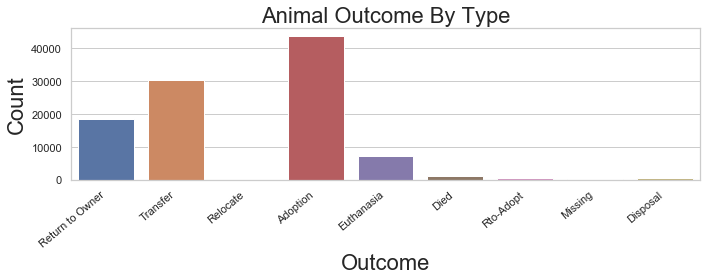

In [21]:
# plotting animal outcomes by type of outcome

plt.figure(figsize=(10,4))
ax = sns.countplot(df['outcome_type'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Outcome', fontsize = 22)
plt.ylabel('Count', fontsize = 22)
plt.title('Animal Outcome By Type', fontsize = 22)
plt.tight_layout()
plt.show()

In [22]:
# Going to focus on increasing live feline outcomes, so I need to drop 
# data for all other animal species

# Get names of indexes for which animal type column value is not cat
index_names = df[ df['animal_type']!='Cat'].index
 
# Delete these row indexes from dataFrame
df.drop(index_names , inplace=True)

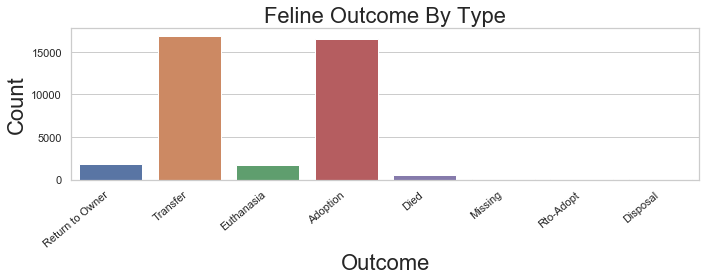

In [23]:
# plotting feline outcomes by type of outcome

plt.figure(figsize=(10,4))
ax = sns.countplot(df['outcome_type'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Outcome', fontsize = 22)
plt.ylabel('Count', fontsize = 22)
plt.title('Feline Outcome By Type', fontsize = 22)
plt.tight_layout()
plt.show()

In [24]:
# making outcome_type binary - either the feline was released alive (1) or 
# not alive (0). All felines that were transfered or returned to owner
# were dropped from dataframe

df['outcome_type'] = df['outcome_type'].replace(['Adoption'], 1)
df['outcome_type'] = df['outcome_type'].replace(['Euthanasia', 'Died', 'Disposal',
                                                'Missing'], 0)
df['outcome_type'] = df['outcome_type'].replace(['Transfer', 'Return to Owner', 'Rto-Adopt'], 3)

df.rename(index=str, columns={'outcome_type': 'adopted'}, inplace=True)

In [25]:
# Get names of indexes for which live_release value is not 0 or 1 and drop those rows
index_names = df[df['adopted']==3].index

# Delete these row indexes from dataFrame
df.drop(index_names , inplace=True)

In [26]:
df.head(1)

,age_upon_outcome,datetime_outcome,monthyear,name_outcome,outcome_subtype,adopted,sex_upon_outcome,age_upon_outcome_in_days,age_upon_outcome_in_years,outcome_month,outcome_year,outcome_weekday,animal_type,breed,color,intake_condition,intake_type,name_intake,sex_upon_intake,age_upon_intake_in_days,age_upon_intake_in_years,intake_datetime,intake_month,intake_year,intake_weekday,intake_number,time_in_shelter,age_at_intake,age_at_outcome,intake_date,outcome_date
animal_id_new,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A214991_1,19 years,2013-12-14T13:28:00.000,2013-12-14T13:28:00.000,Prissy,Suffering,0.0,Spayed Female,6935,19.0,12,2013,Saturday,Cat,Domestic Shorthair,Black,Aged,Euthanasia Request,Prissy,Spayed Female,6935,19.0,2013-12-14 11:51:00,12,2013,Saturday,1.0,01:37:00,7228 days 11:51:00,7228 days 13:28:00,2013-12-14,2013-12-14


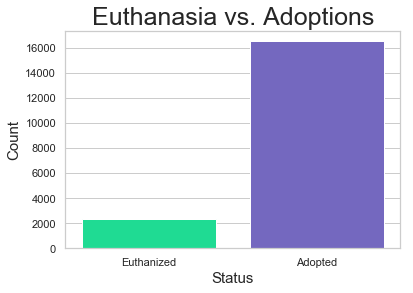

In [27]:
# plot feline euthanasia vs. adoptions

sns.countplot(df['adopted'], palette=('mediumspringgreen', 'slateblue'))
plt.title('Euthanasia vs. Adoptions', fontsize=25)
plt.xticks(np.arange(2), labels=['Euthanized','Adopted'])
plt.xlabel('Status', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [28]:
df['adopted'].value_counts()

1.0    16521
0.0     2296
Name: adopted, dtype: int64

In [ ]:
sns.countplot(df['name_outcome'], palette=('mediumspringgreen', 'slateblue'))
plt.title('Named', fontsize=30)
plt.xticks(np.arange(2), labels=['Not Named','Named'])
plt.xlabel('Named', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [ ]:
sns.countplot(df['out_neut_spay'], palette=('mediumspringgreen', 'slateblue'))
plt.title('Spay Neuter Out', fontsize=30)
plt.xticks(np.arange(2), labels=['Not S/N','S/N'])
plt.xlabel('Sterilization', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [ ]:
sns.countplot(df['int_neut_spay'], palette=('mediumspringgreen', 'slateblue'))
plt.title('Spay Neuter In', fontsize=30)
plt.xticks(np.arange(2), labels=['Not S/N','S/N'])
plt.xlabel('Sterilization', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [ ]:
# sns.countplot(df['intake_condition'])
# plt.title('Intake Condition')
# plt.xticks(np.arange(2), labels=['Sick or Injured','Normal'])
# plt.show()

# plotting feline intake condition

plt.figure(figsize=(10,10))
ax = sns.countplot(df['intake_condition'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Intake Condition', fontsize = 22)
plt.ylabel('Count', fontsize = 22)
plt.title('Intake Conditions', fontsize = 22)
plt.tight_layout()
plt.show()

In [ ]:
len(df)

In [ ]:
sns.countplot(df['adopted'])
plt.title('Int')
plt.xticks(np.arange(2), labels=['Sick or Injured','Normal'])
plt.show()

In [ ]:
df['adopted'].value_counts()

In [29]:
#making name column binary: 0 for no name, 1 for named

df['name_outcome'].fillna(0, inplace=True)
df["name_outcome"]=df["name_outcome"].apply(lambda x: 1 if x!=0 else 0)

df.drop('name_intake', axis=1, inplace=True)

In [30]:
df=df.drop('outcome_subtype', axis=1)

## Feature Engineering

In [32]:
"""
Having domain knowledge from animal shelter volunteer experience, 
many people prefer to adopt younger cats. Knowing this, I broke
the age upon intake and age upon outcome into 4 bins:

- less than 4 months old (young kitten)
- 4 months through 1 year (older kitten)
- 1 year through 9 years (adult)
- over 9 years (senior)

"""

'\nHaving domain knowledge from animal shelter volunteer experience, \nmany people prefer to adopt younger cats. Knowing this, I broke\nthe age upon intake and age upon outcome into 4 bins:\n\n- less than 4 months old (young kitten)\n- 4 months through 1 year (older kitten)\n- 1 year through 9 years (adult)\n- over 9 years (senior)\n\n'

In [33]:
# Bin Ages
bins = [0, 120, 365, 3285, 8030]
in_life_stages = pd.cut(df['age_upon_intake_in_days'], bins)
# Create dummy variables for 'age_range'
in_life_stage_dummies = pd.get_dummies(in_life_stages, prefix="int_age_")
#Add the dummy variables to the main dataframe
df = pd.concat([df, in_life_stage_dummies], axis=1)

In [34]:
# Bin Ages
bins = [0, 120, 365, 3285, 8030]
out_life_stage = pd.cut(df['age_upon_outcome_in_days'], bins)
# Create dummy variables for 'age_range'
out_life_stage_dummies = pd.get_dummies(out_life_stage, prefix="out_age_")
#Add the dummy variables to the main dataframe
df = pd.concat([df, out_life_stage_dummies], axis=1)

In [ ]:
"""
Coverting intake and outcome dates into season:

- winter: Dec - Feb
- spring: Mar - May
- summer: June - Aug
- fall: Sept - Nov

"""

In [35]:
# Build a season_column
seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']

df['intake_season'] = df['intake_date'].map(lambda x: seasons[x.month-1])

int_season_dummies = pd.get_dummies(df['intake_season'], prefix="int_season_")
int_season_dummies.head()

df = pd.concat([df, int_season_dummies],axis=1)

to_drop = ['intake_date', 'intake_season', 'age_upon_intake_in_days',
          'age_upon_intake_in_years', 'age_upon_intake_in_years',
          'age_at_intake', 'intake_month']
df.drop(to_drop, axis=1, inplace=True)

In [36]:
# Build a season_column and dummy
seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']

df['outcome_season'] = df['outcome_date'].map(lambda x: seasons[x.month-1])

out_season_dummies = pd.get_dummies(df['outcome_season'], prefix="out_season_", drop_first=True)
out_season_dummies.head()

df = pd.concat([df, out_season_dummies],axis=1)

to_drop = ['outcome_date', 'outcome_season', 'age_upon_outcome_in_days',
          'age_upon_outcome_in_years', 'age_upon_outcome_in_years',
          'age_at_outcome', 'age_upon_outcome', 'outcome_month']
df.drop(to_drop,axis=1, inplace=True)

In [ ]:
"""
Converting the intake and outcome day of the week into 
a binary:

- weekday: 1
- weekend:0

"""

In [37]:
#making outcome and intake days binary: 1 for weekday and 0 for weekend

df['outcome_weekday'] = df['outcome_weekday'].replace(['Monday', 'Tuesday',
                                                    'Wednesday', 'Thursday', 'Friday'], 1)
df['outcome_weekday'] = df['outcome_weekday'].replace(['Saturday', 'Sunday'], 0)

df['intake_weekday'] = df['intake_weekday'].replace(['Monday', 'Tuesday',
                                                    'Wednesday', 'Thursday', 'Friday'], 1)
df['intake_weekday'] = df['intake_weekday'].replace(['Saturday', 'Sunday'], 0)

In [ ]:
"""
Drop all rows where animal type is not a cat.
"""

In [38]:
# Get names of indexes for which column animal_type has value Bird
indexNames = df[df['animal_type'] == 'Bird'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# Get names of indexes for which column animal_type has value Other
indexNames = df[df['animal_type'] == 'Other'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# Get names of indexes for which column animal_type has value Livestock
indexNames = df[df['animal_type'] == 'Livestock'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [39]:
#dropping unneccessary columns

to_drop = ['intake_datetime', 'intake_year', 'datetime_outcome', 'monthyear', 'outcome_year']
df.drop(to_drop, axis=1, inplace=True)

In [ ]:
"""
Splitting the sex upon intake and sex upon outcome columns 
into two separate columns of spayed/neutered and male/female
"""

In [40]:
#split intake neuter/spay/sex column:

# new data frame with split value columns 
new = df['sex_upon_intake'].str.split(" ", n = 1, expand = True) 
  
# making separate spay/neuter column from new data frame 
df['int_neut_spay']= new[0] 
  
    
# Dropping old columns 
df.drop(columns =['sex_upon_intake'], inplace = True) 
  
#split outcome neuter/spay/sex column:
    
# new data frame with split value columns 
new = df['sex_upon_outcome'].str.split(" ", n = 1, expand = True) 
  
# making separate spay/neuter column from new data frame 
df['out_neut_spay']= new[0] 

# making separate sex column from new data frame 
df['female']= new[1] 
  
# Dropping old columns 
df.drop(columns =['sex_upon_outcome'], inplace = True) 

In [ ]:
"""
Making sex columns and sterilization columns binary 
"""

In [41]:
# make sex column binary

df['female'] = [1 if x== 'Female' else 0 for x in df['female']]

In [42]:
#1 for cat/dog is spayed or neutured
#0 for intact and other

df['int_neut_spay'] = df['int_neut_spay'].replace(['Intact', 'Spayed', 'Neutered', 'Unknown'], [0, 1, 1, 0])
df['out_neut_spay'] = df['out_neut_spay'].replace(['Intact', 'Spayed', 'Neutered', 'Unknown'], [0, 1, 1, 0])

In [ ]:
"""
Dummy animal type column
"""

In [43]:
#dummy animal_type category

animal_type_dummies = pd.get_dummies(df['animal_type'], prefix="animal_type_")
animal_type_dummies.head()

df = pd.concat([df, animal_type_dummies],axis=1)
df.drop('animal_type',axis=1, inplace=True)

In [44]:
# make intake condition binary: 1 for normal

df['intake_condition'] = [1 if x== 'Normal' else 0 for x in df['intake_condition']]

In [45]:
#dummy intake_type

intake_type_dummies = pd.get_dummies(df['intake_type'], prefix="int_type_")
intake_type_dummies.head()

df = pd.concat([df, intake_type_dummies],axis=1)
df.drop('intake_type',axis=1, inplace=True)

In [46]:
#change time in shelter type

df['time_in_shelter'] = df['time_in_shelter'].astype('timedelta64[D]')

In [47]:
# drop rows with time in shelter that is less than 0

# Get names of indexes for which column Age has value 30
indexNames = df[ df['time_in_shelter'] <0].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [ ]:
"""
Bin time in shelter to:

- less than 30 days
- less than 1 year
- over 1 year

"""

In [48]:
# Bin time in shelter

bins = [0, 30, 365, 1469]
days_in_shelter = pd.cut(df['time_in_shelter'], bins)
# Create dummy variables for 'time in shelter'
days_in_shelter_dummies = pd.get_dummies(days_in_shelter, prefix="days_in_")
#Add the dummy variables to the main dataframe
df = pd.concat([df, days_in_shelter_dummies], axis=1)

df.drop('time_in_shelter', axis=1, inplace=True)

In [ ]:
"""
The breed column includes domestic breeds, pure
breds, and mixes and that all needs to be 
separated out into their own columns

Handling the breed column:`

- making breed column lowercase
- creating binary mix column for breeds that are mixes
- separating breeds out as domenstic or pure bred per 
  the Cat Fancier's Association  

"""

In [55]:
df['breed'] = df['breed'].str.lower()

In [56]:
# creates a binary mix column where if the breed column contains a mix 
# breed, mix = 1
df['mix'] = np.where(df['breed'].str.contains("mix"), 1, 0)

In [57]:
# Creating a temporary breed_edit column.
# Dropping "mix", replacing "medium hair" with "mediumhair" for consistency, and lower-casing.

df['breed_edit'] = df['breed'].str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()

In [58]:
#creating a list of CFA breeds
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

cfa_breeds

'abyssinian|american bobtail|american curl|american shorthair|american wirehair|balinese|bengal|birman|bombay|british shorthair|burmese|burmilla|chartreux|colorpoint shorthair|cornish rex|devon rex|egyptian mau|european burmese|exotic|havana brown|japanese bobtail|korat|laperm|maine coon|manx|norwegian forest cat|ocicat|oriental|persian|ragamuffin|ragdoll|russian blue|scottish fold|selkirk rex|siamese|siberian|singapura|somali|tonkinese|turkish angora|turkish van'

In [59]:
# Splitting records with two breeds into two columns for each breed.
df = pd.concat([df, df['breed_edit'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

# If the columns is in the cfa list, mark as 1.
df['cfa_breed'] = np.where((df['breed1'].str.contains(cfa_breeds)) | 
                                (df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

# If neither breed1 or breed2 columns contain a cfa recognized breed, mark as domestic.
df['domestic_breed'] = np.where((df['breed1'].str.contains(cfa_breeds) == False) | 
                                     (df['breed2'].str.contains(cfa_breeds) == False), 
                                     1, 0)

In [60]:
df.drop(['breed_edit', 'breed1', 'breed2', 'breed'], axis=1, inplace=True)

In [ ]:
#df.drop('mix', axis=1, inplace=True)

In [61]:
df['domestic_breed'].value_counts()

1    17692
0     1079
Name: domestic_breed, dtype: int64

In [ ]:
"""
The color column contains both coat colors and 
coat patterns. These need to be separated out 
into their own columns.
"""

In [63]:
# Coat patterns list for cats
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

In [64]:
# Create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

coat_reg

'(tabby|tortie|tortoiseshell|calico|smoke|torbie|colorpoint|point|brindle|agouti|bicolor|tricolor)'

In [66]:
# Extracting coat pattern from color and removing it from color column
df['color'] = df['color'].str.lower()

df['coat_pattern'] = df['color'].str.extract(coat_reg, expand=False)

df['color_edit'] = df['color'].str.replace(coat_reg, '').str.strip()

In [67]:
#Splitting color column into two color columns
df = pd.concat([df, df['color_edit'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

#Replacing blanks in color1 with 'breed specific'.
df['color1'] = np.where(df['color1'] == '', 'breed specific', df['color1'])

# Creating a column that collects the extracted coat colors and patterns.  If the color is breed specific, list 
# the coat pattern.  Otherwise, list the color.
df['coat'] = np.where(df['color1'] == 'breed specific', df['coat_pattern'], df['color1'])

In [68]:
df.drop(['coat_pattern', 'color_edit', 'color1', 'color2', 'color'], axis=1, inplace=True)

In [69]:
#dummy animal coat category

coat_dummies = pd.get_dummies(df['coat'], prefix="coat_")
coat_dummies.head()

df = pd.concat([df, coat_dummies],axis=1)
df.drop('coat', axis=1, inplace=True)

In [70]:
#drop the 4 nans that were still in table

df = df.dropna(how='any')           # assign back
df.dropna(how='any', inplace=True)  # set inplace parameter

In [71]:
df.drop(columns=['animal_type__Cat'],inplace=True)

In [72]:
# make intake number column binary

df['intake_number'] = [0 if x== 1.0 else 1 for x in df['intake_number']]

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18770 entries, A214991_1 to A798165_1
Data columns (total 78 columns):
name_outcome                    18770 non-null int64
adopted                         18770 non-null int64
outcome_weekday                 18770 non-null int64
intake_condition                18770 non-null int64
intake_weekday                  18770 non-null int64
intake_number                   18770 non-null int64
int_age__(0, 120]               18770 non-null uint8
int_age__(120, 365]             18770 non-null uint8
int_age__(365, 3285]            18770 non-null uint8
int_age__(3285, 8030]           18770 non-null uint8
out_age__(0, 120]               18770 non-null uint8
out_age__(120, 365]             18770 non-null uint8
out_age__(365, 3285]            18770 non-null uint8
out_age__(3285, 8030]           18770 non-null uint8
int_season__fall                18770 non-null uint8
int_season__spring              18770 non-null uint8
int_season__summer              1877

In [76]:
df['adopted'] = df['adopted'].astype(int)

In [ ]:
# #split color column:

# # new data frame with split value columns 
# new = df['color'].str.split("/", n = 1, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['color_1']= new[0] 
# #df['color_2']= new[1] 
# #df['color_3']= new[1] 
    
# # Dropping old columns 
# df.drop(columns =['color'], inplace = True) 

In [ ]:
# # split color column

# new = df['color_1'].str.split(" ", n = 1, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['color']= new[0] 

# # Dropping old columns
# df.drop(columns =['color_1'], inplace = True) 

In [ ]:
# #replacing colors of animals with low observations to others

# df['color'] = df['color'].replace(['Yellow', 'Fawn', 'Buff', 'Lynx', 
#                                    'Seal', 'Silver', 'Flame', 'Gold', 
#                                    'Lilac', 'Apricot', 'Liver', 'Agouti', 
#                                    'Pink', 'Ruddy', 'Tan', 'Tricolor', 'Red', 'Sable'], 'Other')
# df['color'] = df['color'].replace(['Chocolate'], 'Brown')


In [ ]:
# #split breed column:

# # new data frame with split value columns 
# new = df['breed'].str.split("/", n = 2, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['breed_1']= new[0] 
# #df['color_2']= new[1] 
# #df['color_3']= new[1] 
    
# # Dropping old columns 
# df.drop(columns =['breed'], inplace = True) 

In [ ]:
# #changing the same bt multiply names breeds into single categories 

# df['breed_1'] = df['breed_1'].replace(['Domestic Shorthair Mix', 'American Shorthair', 'American Shorthair Mix', 
#                                        'Domestic Shorthair'], 'Domestic_Short_Hair')
# df['breed_1'] = df['breed_1'].replace(['Domestic Medium Hair Mix', 'Domestic Medium Hair'], 'Domestic_Medium_Hair_Mix')
# df['breed_1'] = df['breed_1'].replace(['Domestic Longhair Mix', 'Domestic Longhair'], 'Domestic_Longhair')
# df['breed_1'] = df['breed_1'].replace(['Domestic Longhair Mix', 'Domestic Longhair'], 'Domestic_Longhair')
# df['breed_1'] = df['breed_1'].replace(['Siamese Mix'], 'Siamese')

In [ ]:
# #split color column:

# # new data frame with split value columns 
# new = df['breed_1'].str.split(" ", n = 1, expand = True) 
  
# # making separate spay/neuter column from new data frame 
# df['breed']= new[0] 
# #df['color_2']= new[1] 
# #df['color_3']= new[1] 
    
# # Dropping old columns 
# df.drop(columns =['breed_1'], inplace = True) 

In [ ]:
# #replacing breeds of animals with low observations to others (this may be redundant
# #based on following code)

# #replacing breeds of animals with low observations to others

# a = df.breed.value_counts()
# m = df.breed.isin(a.index[a<100])


# df.loc[m, 'breed'] = 'Other'


In [ ]:
# #dummy breeds

# breed_dummies = pd.get_dummies(df['breed'], prefix="breed")
# breed_dummies.head()

# df = pd.concat([df, breed_dummies],axis=1)
# df.drop(['breed'], axis=1, inplace=True)

## Feature Selection

In [79]:
#running a baseline model

target = pd.DataFrame(df, columns = ['adopted'])
features = df.drop(['adopted'], axis=1)

regression = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=17, test_size=0.2)

# crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
# baseline = np.mean(cross_val_score(regression, , y, scoring="r2", cv=crossvalidation))


#create our estimator
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))
print('Test F1 Score: ', f1_score(y_test, lr_y_pred))
print('Test Accuracy Score: ', accuracy_score(y_test, lr_y_pred))

[[ 366   95]
 [  28 3265]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       461
           1       0.97      0.99      0.98      3293

   micro avg       0.97      0.97      0.97      3754
   macro avg       0.95      0.89      0.92      3754
weighted avg       0.97      0.97      0.97      3754

Test F1 Score:  0.9815120998045994
Test Accuracy Score:  0.9672349493873202


In [ ]:
"""
From confusion matrix:
    
True Positive: 3265
False Negative: 28
True Negative: 366
False Positive: 95

False positives are cats that were predicted as live release
(adopted) but were actually euthanized.

False negatives are cats that were predicted as euthanized 
but were actually live released.

Need to focus on a cat that is predicted as live release (adopted)
but is euthanized, therefore, I am concerned with having low false
positives and high precision. 

"""

## Use F-Test to View Top Variables

In [ ]:
selector=SelectKBest(f_regression, k=40)
selector.fit(X_train, y_train)
best_columns = X_train.columns[selector.get_support()]
other_columns = X_train.columns[~selector.get_support()]

In [ ]:
list(best_columns)

In [ ]:
list(other_columns)

In [ ]:
# X_train = X_train[best_columns]
# X_test = X_test[best_columns]

## Use Recursive Feature Elimination

In [ ]:
ols = linear_model.LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

In [ ]:
selected_columns = X_train.columns[selector.support_]
removed_columns = X_train.columns[~selector.support_]

In [ ]:
len(list(selected_columns))

In [ ]:
list(selected_columns)

In [ ]:
list(removed_columns)

## Removing Variables Based on Correlation Coeeficient

In [ ]:
#Plots a heatmap of correlation between features with masking
fig, ax = plt.subplots(figsize=(20,20))
mask=np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
color_map = sns.color_palette("hot_r")
ax = sns.heatmap(df.corr(), cmap = color_map, mask=mask, square=True, annot=True)

In [ ]:
# Find index of feature columns with correlation greater than 0.95
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

## Handling Class Imbalance/Resampling

In [ ]:
# features from baseline model are best features

In [ ]:
len(features.columns)

In [ ]:
sns.countplot(df['adopted'])
plt.title('Adoptions of Cats Compared to Euthanasia')
plt.show()

## Run a Classification Model with Class Imbalance

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred_test = lr_clf.predict(X_test)
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))
# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

In [ ]:
#concatenate our training data back together

training = pd.concat([X_train, y_train], axis=1)

#separate minority and majority classes

euth = training[training['adopted'] == 0]
adopt = training[training['adopted'] == 1]

In [ ]:
#get a class count to understand the class imbalance

print('Euthanasia Count: ' + str(len(euth)))
print('Adoption Count: ' + str(len(adopt)))

In [ ]:
# Over-Sampling: SMOTE

sm = SMOTE(random_state=17, ratio=1.0)
X_resampled1, y_resampled1 = sm.fit_sample(X_train, y_train)

smote_lr = LogisticRegression(solver='liblinear')
smote_lr.fit(X_resampled1, y_resampled1)
smote_pred = smote_lr.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))
print('Test F1 score: ', f1_score(y_test, smote_pred))

print(confusion_matrix(y_test, smote_pred))
print(classification_report(y_test, smote_pred))

# smote_dt = DecisionTreeClassifier(max_depth=5)
# smote_dt.fit(X_resampled1, y_resampled1)
# smote_pred = smote_dt.predict(X_test)
# checking accuracy
# checking accuracy

In [ ]:
# Under-Sampling: Tomek Links

tl = TomekLinks()
X_resampled2, y_resampled2 = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled2))

In [ ]:
# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_resampled2, y_resampled2)

In [ ]:
tomek_lr = LogisticRegression()
tomek_lr.fit(X_resampled, y_resampled)
tomek_pred = tomek_lr.predict(X_test)
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))
# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred))

print(confusion_matrix(y_test, tomek_pred))
print(classification_report(y_test, tomek_pred))

In [ ]:
len(X_train)

In [ ]:
len(X_resampled2)

## Run Models: Use Grid Search for Hyperparameter Tuning

### Decision Tree

In [ ]:
# creating our parameters to test
parameters={'criterion': ['gini','entropy'], 
            'min_samples_leaf' : range(5,100,15),
            'max_depth': range(2,20,1)}
#create our estimaor
clf_tree=DecisionTreeClassifier(random_state=1)
#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1', verbose=2)
#fit the Gridsearch to our data
grid_tree.fit(X_resampled,y_resampled)

In [ ]:
# Examine the best model

# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

In [ ]:
#Predict the response for test dataset
y_pred = grid_tree.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(classification_report(y_test, y_pred))

In [ ]:
# Sensitivity of model: Percentage of positives correctly identified
print('The sensitivity is: ' + str(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])))

# Specificity of the model: Percentage of negatives correctly identified
print('The specificity is: ' + str(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])))

The model has high sensitivity and ok specificity. This means that the model is very good at predicting both adoptions and is ok at predicting not adoptions.

false negatives (30 instances where the model predicted not adoption when it was an adoption) 
false positive (97 instances where the model predicted adoption when it wasn't an adoption)

In [ ]:
# # Render our tree.
# dot_data = tree.export_graphviz(
#     clf_tree, out_file=None,
#     feature_names=X_resampled.columns,
#     class_names=['Not Adopted', 'Adopted'],
#     filled=True
# )
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

In [ ]:
# #how important each feature ended up being in our Decision Tree model
#grid_tree.feature_importances_

In [ ]:
# def plot_feature_importances(model):
#     n_features = X_train.shape[1]
#     plt.figure(figsize=(8,8))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), X_train.columns.values) 
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")

# plot_feature_importances(grid_tree)

### Bagged Trees

In [ ]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

In [ ]:
bagged_tree.fit(X_train, y_train)

In [ ]:
#accuracy score for training data
bagged_tree.score(X_train, y_train)
#accuracy score for testing data
bagged_tree.score(X_test, y_test)
#accuracy score for testing data

#print(confusion_matrix(y_test, smote_pred))
#print(classification_report(y_test, smote_pred))

### Random Forests

In [ ]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

#should I be using X_resampled and y_resampled?

In [ ]:
y_pred = forest.fit(X_train, y_train).predict(X_train)

In [ ]:
#accuracy score for training data
print(forest.score(X_train, y_train))
#accuracy score for testing data
print(forest.score(X_test, y_test))

print(cross_val_score(forest, features, target, cv=5))

In [ ]:
confusion_matrix(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))

In [ ]:
feature_importances = forest.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': features.columns}, 
                           index=features.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

In [ ]:
# #plotting the important features in our random forest
# plot_feature_importances(forest)

In [ ]:
#Making max_features smaller will lead to very different trees in your forest!
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(X_train, y_train)

In [ ]:
#looking at the first tree in forest_2
rf_tree_1 = forest_2.estimators_[0]

In [ ]:
# #plotting the important features in the first tree of forest 2
# plot_feature_importances(rf_tree_1)

In [ ]:
#looking at the second tree in forest_2
rf_tree_2 = forest_2.estimators_[1]

In [ ]:
#plotting the important features in the second tree of forest 2
plot_feature_importances(rf_tree_2)

### Logistic Regression

In [ ]:
lr_clf = LogisticRegression()
parameters = {'penalty':['l1', 'l2'],
             'C': [.5,1,.1]}
grid_lr=GridSearchCV(estimator=lr_clf, param_grid=parameters, cv=5, scoring='f1')
grid_lr.fit(X_resampled, y_resampled)

In [ ]:
# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)

In [ ]:
#Predict the response for test dataset
y_pred_lr = grid_lr.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("F1:",metrics.f1_score(y_test, y_pred_lr))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

### KNN

In [ ]:
# # Run a KNN Model with the Resampled Data
# knn = KNeighborsClassifier(metric='euclidean')
# parameters = {'n_neighbors':[1,2,3,4,5],
#               'weights':['uniform', 'distance'], 
#               'leaf_size':[15,30],
#               'p':[1,2]}
# grid_knn=GridSearchCV(estimator = knn, param_grid=parameters, cv=5, scoring='f1', verbose=2)
# grid_knn.fit(X_resampled2, y_resampled2)

In [ ]:
# # Single best score achieved across all params (min_samples_split)
# print(grid_knn.best_score_)

# # Dictionary containing the parameters (min_samples_split) used to generate that score
# print(grid_knn.best_params_)

In [ ]:
# #Predict the response for test dataset
# y_pred_knn = grid_knn.best_estimator_.predict(X_test)

# # Model Accuracy, how often is the classifier correct?
# print("F1:",metrics.f1_score(y_test, y_pred_knn))
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred_knn))
# print("Precision:",metrics.precision_score(y_test, y_pred_knn))
# print("Recall:",metrics.recall_score(y_test, y_pred_knn))

# print(confusion_matrix(y_test, y_pred_knn))
# print(classification_report(y_test, y_pred_knn))

In [ ]:
# #Create DataFrame with all 2 degree Interactions & Polynomials

# # Create new df
# p = PolynomialFeatures(degree=2).fit(df)
# features = pd.DataFrame(p.transform(df), columns=p.get_feature_names(df.columns))

# # Do not include interactions with price_log
# col_list = list(features.columns)
# to_remove = list(filter(lambda col : "price" in col,col_list))
# to_remove.remove('outcome_type')
# features.drop(to_remove,axis=1,inplace=True)


In [ ]:
# #Create DataFrame with Best Interaction & Best Polynomial

# # Get the r2 for each feature independently predicting log_price
# results = []
# for col in features.columns:
#     if col != "outcome_type":
#         model = LinearRegression()
#         remove_list = list(features.columns)
#         remove_list.remove(col)
        
#         model.fit(features.drop(remove_list,axis=1),features.outcome_type)
#         results.append((col,score(features,model,[col])))

# # Sort them to find the best interactions
# best_interaction = sorted(results,key=lambda inst : inst[1],reverse=True)

# #index 0 is the best interaction, 6 is the best polynomial
# selected_interactions = [best_interaction[0],best_interaction[6]]
# selected_model = features.copy()
# remove_these = list(selected_model.columns)
# # keep the best interaction
# for col in selected_interactions:
#     remove_these.remove(col[0])
# # keep original features
# for col in df.columns:
#     remove_these.remove(col)

# # Drop all interactions that are not the best
# selected_model = selected_model.drop(remove_these,axis=1)

In [ ]:
len(df)